##**CIFAR-10 with ResNet**
A Simple CNN cannot reach high enough accuracy on CIFAR-10 images

### How to run the program:
Go to [Runtime] --> [Run all]

Import Deep learning libraries

In [91]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import pandas as pd

##Tuning Parameters
epoch must be set to 50

In [92]:
epochs = 50
learning_rate=0.1

In [93]:
batch_size = 128
num_classes = 10

In [94]:
# Subtracting pixel to improve accuracy
subtract_pixel_mean = True

## Data

###Plot image

In [95]:
def plot_images(x, y_true, y_pred=None, size=(5, 5)):
    assert len(x) == len(y_true) == size[0] * size[1]
    
    fig, axes = plt.subplots(size[0], size[1])
    fig.subplots_adjust(hspace=0.5, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        if x[i].shape[-1] == 1:
          ax.imshow(x[i].reshape(x[i].shape[0], x[i].shape[1]))
        else:
          ax.imshow(x[i])

        if y_pred is None:
            xlabel = "True: {0}".format(y_true[i].argmax())
        else:
            xlabel = "True: {0}, Pred: {1}".format(y_true[i].argmax(), 
                                                   y_pred[i].argmax())

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

##Load Dataset

In [96]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Reshaping the data

In [97]:
if len(x_train.shape) < 4:
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [98]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


## Input Image dimensions

In [99]:
input_shape=x_train.shape[1:]

## Schedule Learning Rate


```
    Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
```



In [100]:
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 25:
        lr = 0.01
    print('Learning rate: ', lr)
    return lr

## ResNet Version 1
ResNet v2 has too many layers and seem to overfit?

In [101]:
# Model name, depth and version
version = 1
n = 3
depth = n * 6 + 2
model_type = 'ResNet%dv%d' % (depth, version)

# ResNet Layer
Found in Keras documentation
2D Convolution-Batch Normalization-Activation stack builder
```
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
```




In [102]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


## Building ResNet v1
From Keras documentation:
ResNet Version 1 Model builder [b]

```
    ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance

```


In [103]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [104]:
model = resnet_v1(input_shape=input_shape, depth=depth)

## Visualizing the model

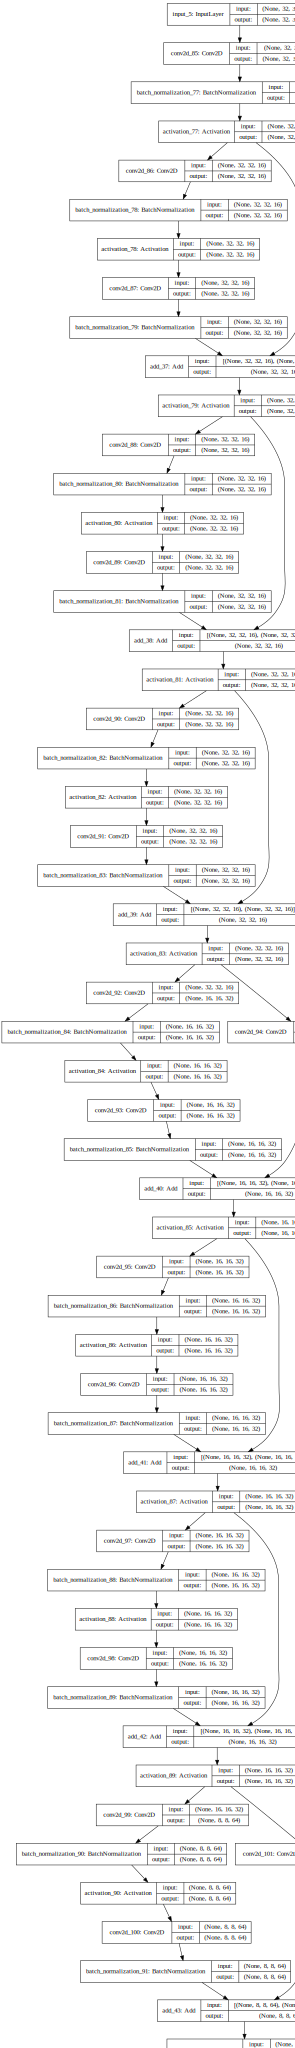

In [105]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Optimizer
Stochastic Gradient Descent as optimizer

In [106]:
optimizer = keras.optimizers.SGD(lr=lr_schedule(0))

Learning rate:  0.1


## Compiling the Model

In [107]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()
print(model_type)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 32, 32, 16)   64          conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 32, 32, 16)   0           batch_normalization_77[0][0]     
____________________________________________________________________________________________

## Learning Rate adjustment with callback

In [108]:
lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

## With Data Augmentation

In [109]:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4, callbacks=callbacks)

Epoch 1/50
Learning rate:  0.1
391/391 [==============================] - 58s 147ms/step - loss: 1.8012 - accuracy: 0.3938 - val_loss: 1.7280 - val_accuracy: 0.4355
Epoch 2/50
Learning rate:  0.1
391/391 [==============================] - 53s 135ms/step - loss: 1.4500 - accuracy: 0.5269 - val_loss: 2.0548 - val_accuracy: 0.4040
Epoch 3/50
Learning rate:  0.1
391/391 [==============================] - 53s 135ms/step - loss: 1.2824 - accuracy: 0.5907 - val_loss: 1.2673 - val_accuracy: 0.5962
Epoch 4/50
Learning rate:  0.1
391/391 [==============================] - 53s 135ms/step - loss: 1.1618 - accuracy: 0.6375 - val_loss: 1.2683 - val_accuracy: 0.6237
Epoch 5/50
Learning rate:  0.1
391/391 [==============================] - 53s 135ms/step - loss: 1.0695 - accuracy: 0.6730 - val_loss: 1.6117 - val_accuracy: 0.5789
Epoch 6/50
Learning rate:  0.1
391/391 [==============================] - 53s 135ms/step - loss: 0.9900 - accuracy: 0.7039 - val_loss: 1.7025 - val_accuracy: 0.5436
Epoch 7/50

## Evaluating Model

In [110]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5607947161197663
Test accuracy: 0.8615000247955322


## Predicting the Model

In [111]:
y_pred = model.predict(x_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

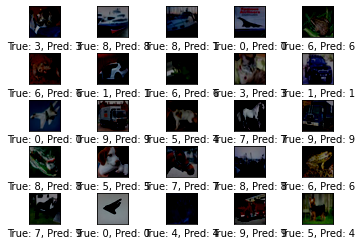

In [112]:
plot_images(x=x_test[:25], y_true=y_test[:25], y_pred=y_pred[:25])

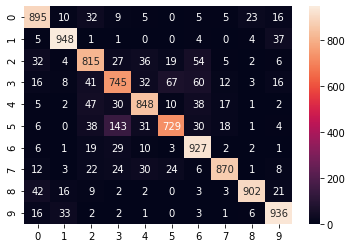

In [113]:
y_result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(pd.DataFrame(y_result, range(10), range(10)), annot=True, fmt='g')